In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu

%matplotlib inline

Using TensorFlow backend.


In [2]:
import os 
import cv2
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv('E:/hackathon DL with CV\hands-on-transfer-learning-with-python-master/hands-on-transfer-learning-with-python-master/notebooks/Ch05 - Unleash the Power of Transfer Learning/train/train.csv')
data.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [4]:
data.groupby('category').count()

,image
category,
1,2120
2,1167
3,916
4,832
5,1217


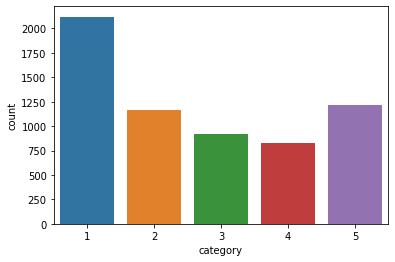

In [5]:
sns.countplot(x='category', data= data)

In [6]:
category = {1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tankers'}
data['categorys'] = data['category'].map(category)

In [7]:
data.head()

,image,category,categorys
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


In [8]:
data['categorys']= data['categorys'].astype('category')

In [9]:
data = data.drop(['category'],1)

In [10]:
target = data['categorys']
print(len(set(target)))
data.head()

5


,image,categorys
0,2823080.jpg,Cargo
1,2870024.jpg,Cargo
2,2662125.jpg,Military
3,2900420.jpg,Carrier
4,2804883.jpg,Military


In [11]:
labels_ohe_names = pd.get_dummies(target, sparse=True)
labels_ohe = np.asarray(labels_ohe_names)
print(labels_ohe.shape)
print(labels_ohe[:5])

(6252, 5)
[[1 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]]


In [12]:
train_folder = 'E:/hackathon DL with CV/hands-on-transfer-learning-with-python-master/hands-on-transfer-learning-with-python-master/notebooks/Ch05 - Unleash the Power of Transfer Learning/train/images/'
data['image_path'] = data.apply(lambda row: (train_folder + row["image"]), axis=1)
data.head()

,image,categorys,image_path
0,2823080.jpg,Cargo,E:/hackathon DL with CV/hands-on-transfer-lear...
1,2870024.jpg,Cargo,E:/hackathon DL with CV/hands-on-transfer-lear...
2,2662125.jpg,Military,E:/hackathon DL with CV/hands-on-transfer-lear...
3,2900420.jpg,Carrier,E:/hackathon DL with CV/hands-on-transfer-lear...
4,2804883.jpg,Military,E:/hackathon DL with CV/hands-on-transfer-lear...


In [13]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img

# load dataset
train_data = np.array([img_to_array(load_img(img, target_size=(150, 150)))
                           for img in data['image_path'].values.tolist()
                      ]).astype('float16')

In [14]:
# create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(train_data, target, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target), 
                                                    random_state=42)

In [15]:
# create train and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [16]:
print('Initial Dataset Size:', train_data.shape)
print('Initial Train and Test Datasets Size:', x_train.shape, x_test.shape)
print('Train and Validation Datasets Size:', x_train.shape, x_val.shape)
print('Train, Test and Validation Datasets Size:', x_train.shape, x_test.shape, x_val.shape)

Initial Dataset Size: (6252, 150, 150, 3)
Initial Train and Test Datasets Size: (3719, 150, 150, 3) (1876, 150, 150, 3)
Train and Validation Datasets Size: (3719, 150, 150, 3) (657, 150, 150, 3)
Train, Test and Validation Datasets Size: (3719, 150, 150, 3) (1876, 150, 150, 3) (657, 150, 150, 3)


In [17]:
# converting to one hotencoding
y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).values
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).values
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).values

y_train_ohe.shape, y_test_ohe.shape, y_val_ohe.shape

((3719, 5), (1876, 5), (657, 5))

In [18]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 64

# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')  # 'nearest' is kind of algorithm to fill pixel values while transformation
train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=True, 
                                     batch_size=BATCH_SIZE, seed=123)
                                     
 

In [19]:
# Create validation generator
val_datagen = ImageDataGenerator(rescale = 1./255)
val_generator = train_datagen.flow(x_val, y_val_ohe, shuffle=True, 
                                   batch_size=BATCH_SIZE, seed=123)   

In [20]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

In [21]:
# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(150, 150, 3))
                             
# Add a global spatial average pooling layer
x = base_inception.output
x = GlobalAveragePooling2D()(x)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(x)

model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = True

In [22]:
# Compile 
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [23]:
# Train the model
batch_size = BATCH_SIZE
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=10, verbose=1)

Epoch 1/10
58/58 [==============================] - 49s 847ms/step - loss: 0.9398 - acc: 0.6316 - val_loss: 0.6201 - val_acc: 0.7797
Epoch 2/10
58/58 [==============================] - 30s 525ms/step - loss: 0.4927 - acc: 0.8138 - val_loss: 0.4866 - val_acc: 0.8246
Epoch 3/10
58/58 [==============================] - 30s 523ms/step - loss: 0.3804 - acc: 0.8575 - val_loss: 0.4047 - val_acc: 0.8381
Epoch 4/10
58/58 [==============================] - 30s 520ms/step - loss: 0.3325 - acc: 0.8642 - val_loss: 0.4030 - val_acc: 0.8516
Epoch 5/10
58/58 [==============================] - 31s 531ms/step - loss: 0.2509 - acc: 0.9087 - val_loss: 0.4264 - val_acc: 0.8432
Epoch 6/10
58/58 [==============================] - 30s 522ms/step - loss: 0.2033 - acc: 0.9272 - val_loss: 0.4708 - val_acc: 0.8398
Epoch 7/10
58/58 [==============================] - 30s 519ms/step - loss: 0.1878 - acc: 0.9299 - val_loss: 0.4156 - val_acc: 0.8718
Epoch 8/10
58/58 [==============================] - 30s 516ms/step - 

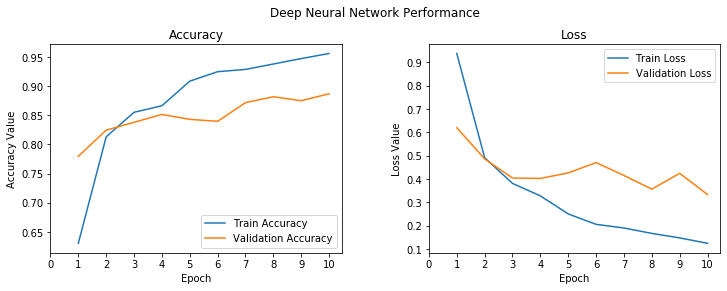

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Deep Neural Network Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [25]:
# scaling test features
x_test /= 255.

# getting model predictions
test_predictions = model.predict(x_test)
test_predictions

array([[1.5234458e-04, 1.9493800e-07, 3.4216355e-06, 9.9984372e-01,
        2.9717808e-07],
       [9.9944359e-01, 1.0099004e-04, 2.4199937e-05, 1.1843713e-05,
        4.1938105e-04],
       [1.2623225e-07, 9.9994373e-01, 9.4274119e-06, 3.7344569e-05,
        9.3853041e-06],
       ...,
       [1.5831864e-02, 2.0685882e-04, 6.9330875e-03, 9.6192980e-01,
        1.5098364e-02],
       [9.8674715e-01, 8.6349821e-05, 1.4466887e-04, 1.2632548e-04,
        1.2895483e-02],
       [3.7348182e-06, 1.7084247e-06, 9.9998844e-01, 5.3411268e-06,
        6.7114456e-07]], dtype=float32)

In [26]:
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
predictions.head()

,Cargo,Carrier,Cruise,Military,Tankers
0,1.523446e-04,1.949380e-07,3.421635e-06,0.999844,2.971781e-07
1,9.994436e-01,1.009900e-04,2.419994e-05,0.000012,4.193810e-04
2,1.262323e-07,9.999437e-01,9.427412e-06,0.000037,9.385304e-06
3,3.480570e-01,6.495880e-02,6.858033e-02,0.129389,3.890150e-01
4,9.998868e-01,3.398173e-06,5.774148e-07,0.000002,1.067528e-04


In [27]:
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['Military',
 'Cargo',
 'Carrier',
 'Tankers',
 'Cargo',
 'Tankers',
 'Cargo',
 'Cruise',
 'Cargo',
 'Cargo']

In [28]:
# evaluate model performance
meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)

Accuracy: 0.9041
Precision: 0.9051
Recall: 0.9041
F1 Score: 0.9043


In [29]:
meu.display_classification_report(true_labels=test_labels, 
                                  predicted_labels=predictions, 
                                  classes=list(labels_ohe_names.columns))

              precision    recall  f1-score   support

       Cargo       0.87      0.90      0.88       636
     Carrier       0.97      0.96      0.96       275
      Cruise       0.92      0.94      0.93       250
    Military       0.98      0.93      0.95       350
     Tankers       0.84      0.82      0.83       365

    accuracy                           0.90      1876
   macro avg       0.92      0.91      0.91      1876
weighted avg       0.91      0.90      0.90      1876

